# Анализ результатов А/В-теста `recommender_system_test`

**Цель проекта** -- изучение результатов А/В-теста по внедрению улучшенной рекомендательной системы

**Исходные данные** в формате `csv`: 
- `final_ab_events` -- действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.
- `ab_project_marketing_events` -- календарь маркетинговых событий на 2020 год
- `final_ab_new_users` -- пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года
- `final_ab_participants` -- таблица участников тестов

**Техническое задание**
- `A` -- контрольная группа, `B` -- новая платежная воронка
- Дата запуска `2020-12-07`, дата окончания `2021-01-04`
- Дата окончания набора новых пользователей `2020-12-21`
- В тесте должны участвовать 15 % новых пользователей региона `EU`
- Участников всего -- 6000
- Прогнозный эффект: улучшение всех метрик не менее чем на 10 % (абсолютный прирост) в течение двухнедельного лайфтайма:
    - конверсия в просмотр карточек (`product_page`)
    - просмотр корзины (`product_cart`)
    - покупки (`purchase`)

## План работ

**Чтение и первичный анализ**

**Предобработка**

- Изучение и обработка пропусков в данных
- Преобразование типов
- Обработка неявных / явных дубликатов
- Вывод

**Проверка на корректность**

- Соответствие ТЗ
- Совпадение времени проведения теста с другими активностями
- Участники тестирования
    - каждый тестируемый в одной группе в течение всего теста
    - участие только в одном тесте
    - равномерность распределения по группам
- Вывод

**Исследовательский анализ**

- Распределение количества событий по пользователям в группах
- Распределение количества событий по дням
- Воронка конверсии для групп
- Вывод

**Анализ результатов теста**

- Применение z-критерия для оценки разницы долей
- Описание результатов
- Вывод

**Общий вывод**

## Чтение и первичный анализ

In [1]:
# pandas
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:,.2f}'.format

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go

# statistics
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.stats.api as sms

# other
from datetime import datetime

In [2]:
# reading from local files

marketing_ev = pd.read_csv('/Users/ilatti/Documents/practicum/final/3_ab_test/data/ab_project_marketing_events.csv')
events = pd.read_csv('/Users/ilatti/Documents/practicum/final/3_ab_test/data/final_ab_events.csv')
new_users = pd.read_csv('/Users/ilatti/Documents/practicum/final/3_ab_test/data/final_ab_new_users.csv')
participants = pd.read_csv('/Users/ilatti/Documents/practicum/final/3_ab_test/data/final_ab_participants.csv')

In [3]:
print(marketing_ev.info())
marketing_ev

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [4]:
print(events.info())
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [5]:
print(new_users.info())
new_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
print(participants.info())
participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [7]:
participants.ab_test.unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

- Все поля с датой в виде текста -- следует перевести в `datetime`
- В самом большом файле свыше 400 тысяч строк
- Пропуски есть только в файле с событиями в колонке деталей -- это нормально, т.к. не все события покупки, но стоит проверить нет ли лишних
- Кроме рассматриваемого теста в датасете есть `interface_eu_test`

## Предобработка

### Пропуски

Изучим пропуски в `events`

In [8]:
events[events.details.isna()].event_name.unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

In [9]:
events[events.details.isna() == False].event_name.unique()

array(['purchase'], dtype=object)

Пропуски соответствуют описанию данных -- колонка `details` не заполнена только для событий `product_cart` `product_page` `login`, а для всех `purchase` заполнена. Оставляем как есть

### Преобразование типов

- Кроме даты, все типы данных столбцов соответствуют содержимому
- Приведем дату к типу `datetime`

In [10]:
events.event_dt = pd.to_datetime(events.event_dt)

print(events.info())
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB
None


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [11]:
marketing_ev.start_dt = pd.to_datetime(marketing_ev.start_dt)
marketing_ev.finish_dt = pd.to_datetime(marketing_ev.finish_dt)

print(marketing_ev.info())
marketing_ev.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
None


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [12]:
new_users.first_date = pd.to_datetime(new_users.first_date)

print(new_users.info())
new_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB
None


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Преобразование успешно

### Обработка дубликатов

Проверим наличие неявных дубликатов в регионах и устройствах в `new_users`:

In [13]:
print(new_users.region.unique())
new_users.device.unique()

['EU' 'N.America' 'APAC' 'CIS']


array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

Дубликатов нет

Проверим названия групп в `participants`:

In [14]:
participants.group.unique()

array(['A', 'B'], dtype=object)

Дубликатов нет

Проверим неявные дубликаты в `events` для всех столбцов за вычетом `user_id`

In [15]:
events.duplicated(subset=['event_dt', 'event_name', 'details']).sum()

15416

- Существует вероятность, что в одну секунду два (или больше) пользователя совершили одно и тоже действие
- Даже если это покупка, сумма покупки тоже может совпасть, в особенности для наших данных -- сумм покупки всего четыре вида:

In [16]:
events.groupby('details')['details'].count()

details
4.99      46362
9.99       9530
99.99      5631
499.99     1217
Name: details, dtype: int64

Проверим, не являются ли эти совпадения полными дубликатами:

In [17]:
events.duplicated().sum()

0

Также проверим полные дубликаты в `new_users` и `participants`:

In [18]:
print(new_users.duplicated().sum())
print(participants.duplicated().sum())

0
0


Дублируются ли `user_id` в `new_users` и `participants`?

In [19]:
print(new_users.duplicated(subset='user_id').sum())
print(participants.duplicated(subset='user_id').sum())

0
1602


Скорее всего дубли `user_id` в `participants` связаны с участием одних и тех же пользователей в разных тестах; проверим

In [20]:
duplicates_all = participants[participants.duplicated(subset='user_id')]['user_id']

participants.query('user_id.isin(@duplicates_all)').sort_values(by='user_id').head(10)

,user_id,group,ab_test
17892,001064FEAAB631A1,B,interface_eu_test
235,001064FEAAB631A1,B,recommender_system_test
16961,00341D8401F0F665,A,interface_eu_test
2137,00341D8401F0F665,A,recommender_system_test
8143,003B6786B4FF5B03,A,interface_eu_test
3156,003B6786B4FF5B03,A,recommender_system_test
4768,0082295A41A867B5,A,recommender_system_test
14161,0082295A41A867B5,B,interface_eu_test
15562,00E68F103C66C1F7,B,interface_eu_test
4074,00E68F103C66C1F7,A,recommender_system_test


- Гипотеза подтвердилась
- Скорее всего, группа А конкурирующего теста -- контрольная, т.е. для пользователей не было изменений в продукте
- Если пользователь из группы А конкурирующего теста оказался в любой группе рассматриваемого теста -- это допустимо
- Недопустимо, если пользователь из группы В конкурирующего теста оказался в любой группе рассматриваемого теста
- Удалим пользователей из группы В конкурирующего теста

In [21]:
participants_init = participants.copy() # backup
new_users_init = new_users.copy()
events_init = events.copy()

duplicates = (participants
              .query('user_id.isin(@duplicates_all) and ab_test == "interface_eu_test" and group == "B"')['user_id'])


participants = participants[~participants.user_id.isin(duplicates)]
new_users = new_users[~new_users.user_id.isin(duplicates)]
events = events[~events.user_id.isin(duplicates)]

In [22]:
participants.query('user_id.isin(@duplicates_all)').sort_values(by='user_id').head(20)

,user_id,group,ab_test
16961,00341D8401F0F665,A,interface_eu_test
2137,00341D8401F0F665,A,recommender_system_test
3156,003B6786B4FF5B03,A,recommender_system_test
8143,003B6786B4FF5B03,A,interface_eu_test
13517,00EFA157F7B6E1C4,A,interface_eu_test
2541,00EFA157F7B6E1C4,A,recommender_system_test
5800,0151DAF505060E94,A,recommender_system_test
16086,0151DAF505060E94,A,interface_eu_test
3073,01B9975CAE144B78,A,recommender_system_test
12937,01B9975CAE144B78,A,interface_eu_test


Условие соблюдено, влияние конкурирующего теста снято

Удалим также все значения в `participants`, не относящиеся к рассматриваемому тесту

In [23]:
participants = participants.query('ab_test == "recommender_system_test" ')

### **Вывод**

- Пропуски в данных только в датасете `events` в колонке `details` 
    - Пропуски соответствуют всем событиям, не являющимся событием `purchase`, что соответствует описанию данных
    - Пропуски оставлены в первоначальном виде
- Дата приведена к типу `datetime`
- Обнаружены повторяющиеся `user_id` в `participants` -- 
    - Явление связано с участием одних и тех же пользователей в разных тестах
    - Удалены пересечения пользователей с группой В конкурирующего теста

## Проверка на корректность

Проверим временные границы на соответствие ТЗ

In [24]:
print('events')
print(f'min date: {events.event_dt.min().date()} / max date: {events.event_dt.max().date()}')
print()
print('new_users')
print(f'min date: {new_users.first_date.min().date()} / max date: {new_users.first_date.max().date()}')

events
min date: 2020-12-07 / max date: 2020-12-30

new_users
min date: 2020-12-07 / max date: 2020-12-23


- Начало теста и начало набора пользователей формально соответствуют ТЗ
- Максимальная дата в `new_users` превышает дату остановки набора новых пользователей `2020-12-21`-- могут быть пользователи другого теста, нужно посмотреть подробнее
- Максимальная дата в `events` не достигает даты остановки теста `2021-01-04` -- **тест меньше по продолжительности, чем планировался**

Запишем идентификаторы пользователей, участвующих в тесте, согласно `participants`

In [25]:
target_test_all = participants['user_id']
target_test_A = participants.query('group == "A"')['user_id']
target_test_B = participants.query('group == "B"')['user_id']

Проверим временные границы только для рассматриваемого теста:

In [26]:
for i in [target_test_A, target_test_B]:

    print('events')
    print(f'min date: {events[events.user_id.isin(i)].event_dt.min().date()} / max date: {events[events.user_id.isin(i)].event_dt.max().date()}')
    print()
    print('new_users')
    print(f'min date: {new_users[new_users.user_id.isin(i)].first_date.min().date()} / max date: {new_users[new_users.user_id.isin(i)].first_date.max().date()}')
    print('--------')

events
min date: 2020-12-07 / max date: 2020-12-29

new_users
min date: 2020-12-07 / max date: 2020-12-21
--------
events
min date: 2020-12-07 / max date: 2020-12-30

new_users
min date: 2020-12-07 / max date: 2020-12-21
--------


- Время набора пользователей в группы корректно
- **Последняя дата для пользователей из группы А на день меньше последней даты для пользователей из группы В**

Проверим соответствие доле новых пользователей из `EU`

In [27]:
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


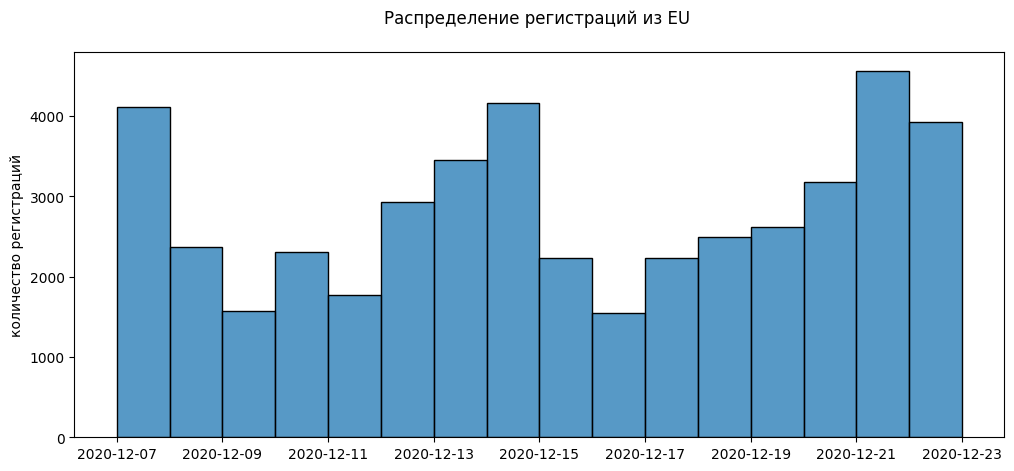

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
sns.histplot(data=new_users.query('region == "EU" '), x='first_date', binwidth=1);
ax.set(xlabel=None, ylabel='количество регистраций', title='Распределение регистраций из EU \n');

Есть регистрации за пределами периода набора новых пользователей в тест `2020-12-07` -- `2020-12-21`, учтем это при расчете доли

In [29]:
new_users_end_date = datetime(2020, 12, 21)
EU_users = new_users.query('region == "EU" and first_date <= @new_users_end_date')

frac_EU = (EU_users.query('user_id.isin(@participants.user_id)').shape[0] / EU_users.shape[0])

print(f'целевая доля: {0.15:.3f} / фактическая доля: {frac_EU:.3f}')
print(f'абсолютное отклонение: {frac_EU - 0.15:.3f} / относительное отклонение: {(frac_EU - 0.15) / 0.15:.1%}')

целевая доля: 0.150 / фактическая доля: 0.134
абсолютное отклонение: -0.016 / относительное отклонение: -10.7%


- Фактическая доля ниже целевой на 11 %: 0.13 вместо 0.15 
- Это снижает охват тестом целевой аудитории -- регион `EU`

Согласно ТЗ в тесте должны участвовать только пользователи региона `EU`, проверим это:

In [30]:
new_users.query('user_id.isin(@target_test_all)').groupby('region')['user_id'].count()

region
APAC           72
CIS            55
EU           5568
N.America     223
Name: user_id, dtype: int64

- Подавляющее большинство пользователей из нужного региона, но есть и пользователи из других регионов
- Пользователи из других регионов снижают ценность теста: поскольку задачей была оценка влияния изменений на пользователей `EU`, то наличие других пользователей размывает оценку, если оставить как есть, то будем оценивать влияние изменений в основном на `EU`, но и в малой степени на другие регионы
- Удалим пользователей из других регионов

In [31]:
EU_users = new_users.query('region == "EU"')['user_id']
participants = participants.query('user_id.isin(@EU_users)')

In [32]:
# refreshing tables with target users
target_test_all = participants['user_id']
target_test_A = participants.query('group == "A"')['user_id']
target_test_B = participants.query('group == "B"')['user_id']


new_users.query('user_id.isin(@target_test_all)').groupby('region')['user_id'].count()

region
EU    5568
Name: user_id, dtype: int64

Посмотрим на количество участников тестирования

In [33]:
print(f'целевое количество участников: {6000:.0f} / фактическое количество участников: {target_test_all.shape[0]:.0f}')
print(f'группа А: {target_test_A.shape[0]:.0f} / группа В: {target_test_B.shape[0]:.0f}')
print(f'отношение  {target_test_A.shape[0] / target_test_all.shape[0]:.0%} / {target_test_B.shape[0] / target_test_all.shape[0]:.0%}')

целевое количество участников: 6000 / фактическое количество участников: 5568
группа А: 3195 / группа В: 2373
отношение  57% / 43%


- **Общее число тестируемых ниже целевого** -- негативное изменение, это снижает охват пользователей тестированием, однако, количество тестируемых достаточно велико
- Группы теста несбалансированы: 57/43 %, что снижает мощность теста, однако, это вряд ли создает трудности: в рамках исследования будем отслеживать достаточно большой эффект в 10 %, который даже со сниженной мощностью маловероятно пропустить (тем более, что дисбаланс не такой уж сильный)
- Подробнее оценим факторы размера выборок позже, когда будем уверены в корректном составе групп, т.к. для уверенного ответа о достаточности объемов выборок можно судить только зная базовую конверсию

Проверим влияние внешних факторов на тест: есть ли наложение маркетинговых активностей во время проведения теста?

In [34]:
marketing_ev

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [35]:
test_start = datetime(2020, 12, 7)
test_end = datetime(2020, 12, 30)

for i in marketing_ev.index:
# condition when there is no intersection with test
    if not ((marketing_ev.loc[i, 'start_dt'] < test_start and marketing_ev.loc[i, 'finish_dt'] < test_start) or 
            (marketing_ev.loc[i, 'start_dt'] > test_end and marketing_ev.loc[i, 'finish_dt'] > test_end)):
# showing problematic events and their regions
        print(marketing_ev.loc[i, 'name'], ' / ', marketing_ev.loc[i, 'regions'])

Christmas&New Year Promo  /  EU, N.America
CIS New Year Gift Lottery  /  CIS


- Есть пересечения по времени с двумя активностями, однако, по географии пересекается только событие `Christmas&New Year Promo`, т.к. все наши тестируемые из `EU`
- Следует проверить: фиксируется ли влияние `Christmas&New Year Promo` на динамике количества событий у пользователей, начиная с `2020-12-25`?
- Если фиксируется, тогда отбросим этим события у пользователей, если нет, тогда оставим

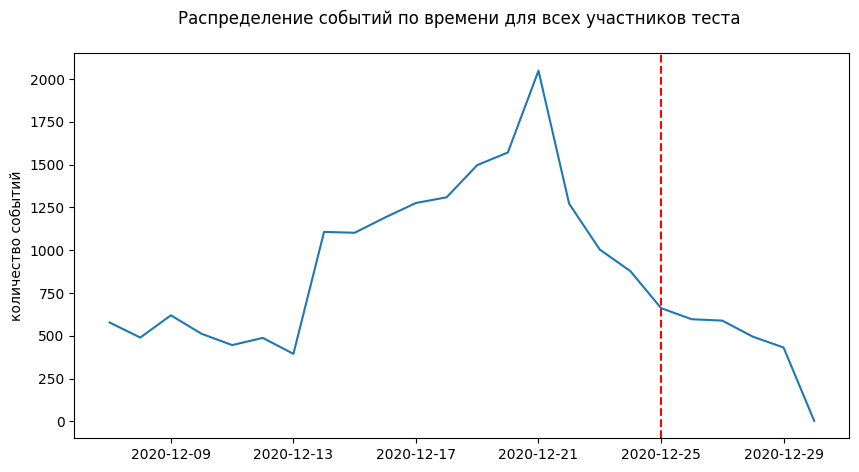

In [36]:
# adding new date column without time of event
events['event_dt_date'] = events.event_dt.dt.date

events_dynamics = (events
                   .query('user_id.isin(@target_test_all)')
                   .groupby('event_dt_date')['user_id']
                   .count()
                   .reset_index()
                   .rename(columns={'user_id':'events_cnt'}))

fig, ax = plt.subplots()
fig.set(size_inches=(10,5))

sns.lineplot(ax=ax, data=events_dynamics, x='event_dt_date', y='events_cnt');
ax.set(xlabel=None, ylabel='количество событий', title='Распределение событий по времени для всех участников теста \n');
ax.axvline(x=datetime(2020, 12, 25), ls='--', color='r');

Посмотрим на динамику для двух тестовых групп в отдельности

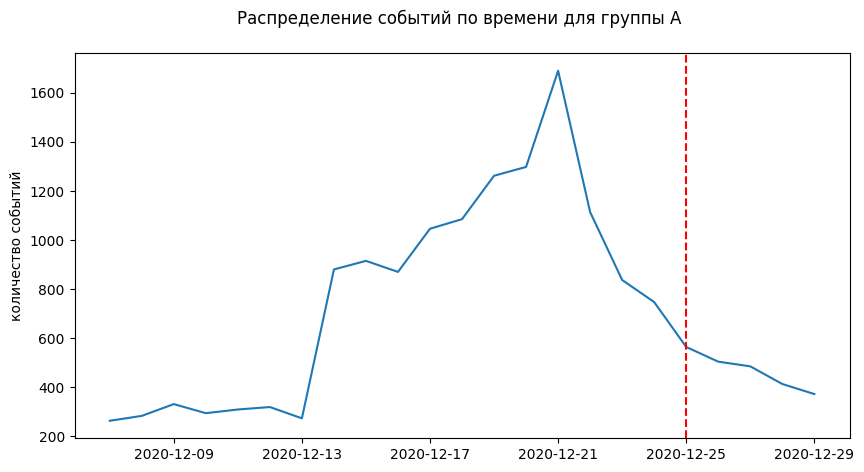

In [37]:
events_dynamics = (events
                   .query('user_id.isin(@target_test_A)')
                   .groupby('event_dt_date')['user_id']
                   .count()
                   .reset_index()
                   .rename(columns={'user_id':'events_cnt'}))

fig, ax = plt.subplots()
fig.set(size_inches=(10,5))
sns.lineplot(ax=ax, data=events_dynamics, x='event_dt_date', y='events_cnt');
ax.set(xlabel=None, ylabel='количество событий', title='Распределение событий по времени для группы А \n');
ax.axvline(x=datetime(2020, 12, 25), ls='--', color='r');

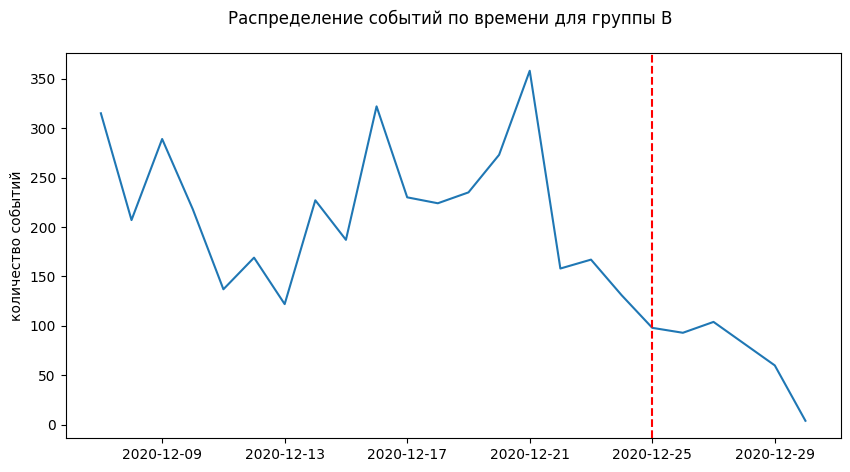

In [38]:
events_dynamics = (events
                   .query('user_id.isin(@target_test_B)')
                   .groupby('event_dt_date')['user_id']
                   .count()
                   .reset_index()
                   .rename(columns={'user_id':'events_cnt'}))

fig, ax = plt.subplots()
fig.set(size_inches=(10,5))
sns.lineplot(ax=ax, data=events_dynamics, x='event_dt_date', y='events_cnt');
ax.set(xlabel=None, ylabel='количество событий', title='Распределение событий по времени для группы В \n');
ax.axvline(x=datetime(2020, 12, 25), ls='--', color='r');

- После `2020-12-21` заметно снижение количества действий для обеих групп
    - Вероятно, явление связано с прекращением набора новых пользователей в эту дату и фактором сезонности
        - Снижение количества действий после прекращения набора новых пользователей в тест косвенно говорит о том, что свои покупки пользователи совершают в начале лайфтайма
        - Можно предположить, что с этой даты и до конца года пользователи прекращают свои новогодние покупки в сервисе
- Наклон динамики остался примерно тем же после начала кампании -- вероятно не было позитивного или негативного воздействия на пользователей
- **Нельзя утверждать, что начало маркетинговой кампании повлияло на результаты теста, поэтому не удаляем события, проходящие в интервал ее проведения**

Проверим условие постоянства тестовой группы для всех участников

In [39]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [40]:
participants.duplicated(subset='user_id').sum()

0

Повторов идентификатора нет, значит, тестовая группа была присвоена единожды каждому пользователю

- Проверим: есть ли такие пользователи, которые не совершили ни одного действия за период проведения эксперимента (даже не залогинились)
- Такие пользователи не дают ответа на то, как изменились конверсии, значит, их можно удалить

In [41]:
users_with_actions = events.user_id.unique()
participants[~participants.user_id.isin(users_with_actions)].shape[0]

2518

Такие пользователи есть, удалим их

In [42]:
participants = participants[participants.user_id.isin(users_with_actions)]

- По ТЗ мы рассматриваем только двухнедельный лайфтайм, действия за этим промежутком для каждого пользователя в расчет брать не нужно
- Удалим для каждого пользователя действия за двухнедельным лайфтаймом

Добавим информацию о регистрации для каждого пользователя в таблицу `events`:

In [43]:
events = events.merge(new_users, how='left', on='user_id')
events.head()

,user_id,event_dt,event_name,details,event_dt_date,first_date,region,device
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,2020-12-07,N.America,iPhone
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,2020-12-07,EU,iPhone
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,2020-12-07,N.America,iPhone
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,2020-12-07,EU,iPhone
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,2020-12-07,EU,Android


In [44]:
events['lifetime'] = events.event_dt - events.first_date
events.lifetime = events.lifetime.dt.days
events.query('lifetime == 1').head()

,user_id,event_dt,event_name,details,event_dt_date,first_date,region,device,lifetime
1636,9CD9F34546DF254C,2020-12-08 07:21:15,purchase,99.99,2020-12-08,2020-12-07,N.America,iPhone,1
1637,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,2020-12-08,2020-12-07,EU,iPhone,1
1638,6B2F726BFD5F8220,2020-12-08 07:31:43,purchase,4.99,2020-12-08,2020-12-07,EU,Android,1
1639,BEB37715AACF53B0,2020-12-08 03:57:34,purchase,4.99,2020-12-08,2020-12-07,EU,Android,1
1640,B5FA27F582227197,2020-12-08 22:51:25,purchase,4.99,2020-12-08,2020-12-07,N.America,Mac,1


Расчет корректен; уберем все события за пределами двух недель лайфтайма,

In [45]:
events = events.query('lifetime <= 13')

In [46]:
participants.user_id.nunique()

3050

In [47]:
events.user_id.nunique()

58262

В событиях пользователей значительно больше, чем в участниках: это нормально, но полезной нагрузки не несет

Добавим информацию о группе теста в `events`, но предварительно отбросим пользователей, не участвующих в тесте:

In [48]:
events = events[events.user_id.isin(participants.user_id)]
events.user_id.nunique()

3050

In [49]:
events = events.merge(participants, how='left', on='user_id')
events.head()

,user_id,event_dt,event_name,details,event_dt_date,first_date,region,device,lifetime,group,ab_test
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,2020-12-07,EU,Android,0,A,recommender_system_test
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,2020-12-07,EU,PC,0,A,recommender_system_test
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07,2020-12-07,EU,iPhone,0,B,recommender_system_test
3,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-07,2020-12-07,EU,PC,0,A,recommender_system_test
4,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07,2020-12-07,EU,PC,0,B,recommender_system_test


- Теперь мы можем рассчитать базовую конверсию для действий `product_page` `product_cart` `purchase` и изучить влияние размеров выборок для регистрации эффекта из ТЗ
- Конверсию рассчитаем от действия `login`
- Посчитаем отношение количества уникальных пользователей для каждого из трех действий из ТЗ к количеству уникальных пользователей на этапе `login`

In [50]:
base_conversions = pd.DataFrame(columns=['product_page', 'product_cart', 'purchase'])
login_users = events.query('event_name == "login" and group == "A"')['user_id'].nunique()

for i in ['product_page', 'product_cart', 'purchase']:
    base_conversions.loc[0, i] = events.query('event_name == @i and group == "A"')['user_id'].nunique() / login_users

base_conversions = base_conversions.rename(index={0:'base conversion'})
base_conversions

,product_page,product_cart,purchase
base conversion,0.65,0.30,0.32


- Детектируемый эффект из ТЗ = 10 % абсолютного прироста в метрику
- Поскольку тест будет множественным -- несколько проверок на одних и тех же данных, то необходимо сделать поправку; возьмем поправку Бонферрони; 
- Оценим величины мощности теста (вероятности корректно принять альтернативную гипотезу) для наших вводных: размеры выборок, регистрируемый эффект, уровень статистической значимости

In [51]:
alpha = .05 / 3 # applying Bonferroni correction for total significance = 5 %
effect = 0.1 # value of detecting effect
nobs1 = participants.query('group == "A"')['user_id'].count() # size of first sample
ratio = participants.query('group == "B"')['user_id'].count() / nobs1 # specifying ratio for unbalanced samples


print('power:\n')
for i in ['product_page', 'product_cart', 'purchase']:
    conv_i = base_conversions.loc['base conversion', i]
    effect_st = sms.proportion_effectsize(conv_i, conv_i + effect) # calculating standardized value of effect
    power_i = sms.NormalIndPower().solve_power(effect_size=effect_st, # calculating power of test
                                           nobs1=nobs1, 
                                           alpha=alpha, 
                                           power=None, 
                                           ratio=ratio, 
                                           alternative='two-sided')

    print(f'{i} {power_i:.1%}')

power:

product_page 99.8%
product_cart 99.6%
purchase 99.5%


Расчеты показывают, что наших выборок достаточно для регистрации эффекта с высокой мощностью (более 99 %) и совокупным уровнем статистической значимости в 5 %

Наконец сравним распределение по устройствам для групп исследования:

In [52]:
participants = participants.merge(new_users, how='left', on='user_id')
participants.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,4FF2998A348C484F,A,recommender_system_test,2020-12-20,EU,Mac


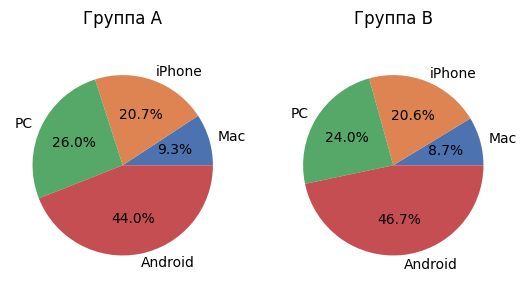

In [53]:
fig, ax = plt.subplots(1, 2)
colors = sns.color_palette('deep')
counter = 0

for i in ['A', 'B']:
    device_pivot = (participants
                    .query('group == @i')
                    .groupby('device')['user_id']
                    .count()
                    .reset_index()
                    .rename(columns={'user_id':'cnt'})
                    .sort_values(by='cnt'))
    
    ax[counter].pie(device_pivot.cnt, labels=device_pivot.device, colors=colors, autopct='%1.1f%%')
    ax[counter].set(title='Группа '+ i + '\n', ylabel=None)
    counter += 1

- Распределение по устройстам практически идентично, наибольшая разница в доле пользователей `Android`: 2.7 %
- Проверим статистическую значимость этой разницы с помощью z-теста
- На текущем этапе проверим только для `Android`, как устройства с наибольшим отклонением; в случае отсутствия различий оставшиеся проверять нет смысла

In [54]:
target_users = [] 
all_users = []

for i in ['A', 'B']:
    target_users.append(participants
                        .query('group == @i and device == "Android"')['user_id']
                        .nunique())
    
    all_users.append(participants
                        .query('group == @i')['user_id']
                        .nunique())


In [55]:
print('H0: доли пользователей Android в группе А и группе В совпадают \nH1: доли пользователей Android в группе А и группе В отличаются\n')
print(f'p-value: {proportions_ztest(target_users, all_users, alternative="two-sided")[1]:.2f} alpha: {0.05:.2f}')


H0: доли пользователей Android в группе А и группе В совпадают 
H1: доли пользователей Android в группе А и группе В отличаются

p-value: 0.20 alpha: 0.05


- Вероятность ошибки при отказе от `H0` превышает принятый уровень значимости
- Не удалось отвергнуть `H0` -- нет статистически значимого различия в долях групп

С точки зрения распределения по типам устройств дизайн исследования корректен

### **Вывод**

- Тест закончен раньше запланированного срока
- Доля новых пользователей из `EU` 13 % вместо 15 % -- снижен охват целевой аудитории тестом
- В тесте участвовали не только пользователи из `EU`, были убраны пользователи из других регионов, чтобы не размывать результат
- Общее число тестируемых ниже целевого: 5500 вместо 6000 по ТЗ
- Есть пересечение с маркетинговой кампанией `Christmas&New Year Promo` с `2020-12-25` и до конца теста (шесть дней)
    - Изменений в динамике событий после начала кампании не обнаружено для обеих групп
- Пользователи не относятся к двум группам сразу
- Есть пользователи, не совершившие ни одного действия
    - В вопросах конверсии действий такие пользователи бесполезны, они удалены
- Все действия за пределами двухнедельного лайфтайма пользователя удалены
- Размеры выборок соответствуют необходимым значениям регистрируемого эффекта, базовым конверсиям и уровню статистической значимости (с поправкой на множественные тесты) 
- Распределение по устройствам в группах совпадает
- **Тест пригоден для изучения**

## Исследовательский анализ

Изучим количество событий на пользователя в выборках

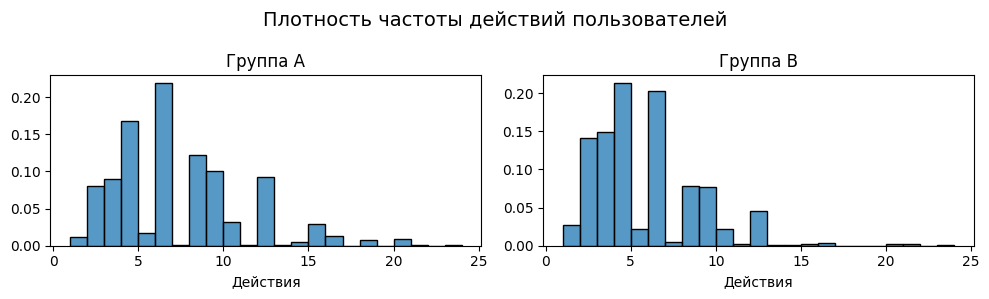

In [56]:
fig, ax = plt.subplots(1, 2)
fig.set(size_inches=(10, 3), tight_layout=True)
fig.suptitle('Плотность частоты действий пользователей', size=14)
counter = 0

for i in ['A', 'B']:
    actions_x_users = (events
                    .query('group == @i')
                    .groupby('user_id')['event_name']
                    .count()
                    .reset_index()
                    .rename(columns={'event_name':'cnt'}))
    
    sns.histplot(ax=ax[counter], 
                 data=actions_x_users, 
                 x='cnt', 
                 bins=26, 
                 stat='density', 
                 common_norm=False, 
                 binwidth=1)
    ax[counter].set(title='Группа '+ i, ylabel=None, xlabel='Действия')
    counter += 1

- Общая форма распределения количества действий у пользователей для групп совпадает
- Ключевое отличие: для группы А больше доля пользователей, совершивших 8-9 действий в сравнении с долей пользователей, совершивших 2-3 действий, а для группы В наоборот
- Больше 15-ти действий для обеих групп -- выбросы
- В обеих группах мало количество пользователей, совершивших одно, пять, семь, десять и одиннадцать действий

In [57]:
cons = []
print('Среднее количество действий на пользователя:\n')
for i in ['A', 'B']:
    act_per_user_i = events.query('group == @i').shape[0] / events.query('group == @i')['user_id'].nunique()
    cons.append(act_per_user_i)
    print(f'Группа {i}: {act_per_user_i:.1f}')
    
print(f'отклонение {(cons[1] - cons[0]) / cons[0]:.1%}')

Среднее количество действий на пользователя:

Группа A: 6.9
Группа B: 5.3
отклонение -22.5%


Получено достаточно большое отклонение, но все же применим t-тест и оценим, является ли оно статистически значимым

In [58]:
sample_A = (events.query('group == "A"')
            .groupby('user_id')['event_name']
            .count())

sample_B = (events.query('group == "B"')
            .groupby('user_id')['event_name']
            .count())
            
p_val = st.ttest_ind(sample_A, sample_B, equal_var=False).pvalue
    
print(f'H0: среднее количество действий группы А не отличается от среднего группы В')
print(f'H1: среднее количество действий группы А отличается от среднего группы В')
print()
if p_val < alpha:
    print('отвергаем нулевую гипотезу в пользу альтернативной')
else: print('не удалось отвергнуть нулевую гипотезу')

H0: среднее количество действий группы А не отличается от среднего группы В
H1: среднее количество действий группы А отличается от среднего группы В

отвергаем нулевую гипотезу в пользу альтернативной


Действительно, в контрольной группе более активные пользователи в сравнении с тестовой группой

Изучим динамику действий во времени:

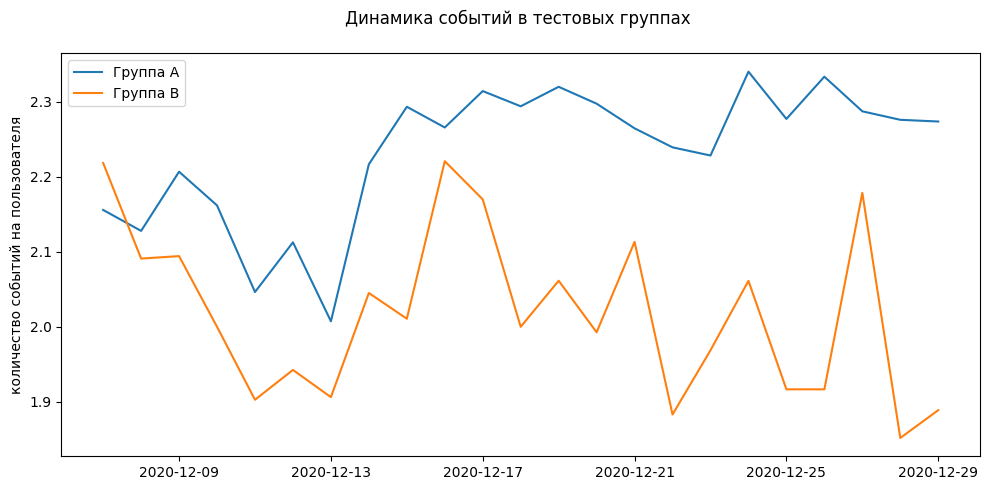

In [59]:
target_test_A = participants.query('group == "A"')['user_id']
target_test_B = participants.query('group == "B"')['user_id']


events_dynamics_A = (events
                   .query('user_id.isin(@target_test_A)')
                   .groupby('event_dt_date')
                   .agg({'user_id':['count', 'nunique']})
                   .reset_index()
                   .droplevel(0, axis=1)
                   )
events_dynamics_A.columns=['event_dt_date', 'events_cnt', 'user_cnt']
events_dynamics_A['events_on_user'] = events_dynamics_A.events_cnt / events_dynamics_A.user_cnt

events_dynamics_B = (events
                   .query('user_id.isin(@target_test_B)')
                   .groupby('event_dt_date')
                   .agg({'user_id':['count', 'nunique']})
                   .reset_index()
                   .droplevel(0, axis=1)
                   )
events_dynamics_B.columns=['event_dt_date', 'events_cnt', 'user_cnt']
events_dynamics_B['events_on_user'] = events_dynamics_B.events_cnt / events_dynamics_B.user_cnt


fig, ax = plt.subplots(sharey=True)
fig.set(size_inches=(10, 5), tight_layout=True)

sns.lineplot(ax=ax, data=events_dynamics_A, x='event_dt_date', y='events_on_user', label='Группа А');
sns.lineplot(ax=ax, data=events_dynamics_B, x='event_dt_date', y='events_on_user', label='Группа В');

ax.set(xlabel=None, ylabel='количество событий на пользователя', title='Динамика событий в тестовых группах \n');

- Количество действий на пользователя в тестовой группе стабильно ниже в сравнении с контрольной
- До `2020-12-16` группы демонстрируют похожую динамику удельного количества действий
- После `2020-12-16` количество действий в группе А стабилизизуется, а в группе В постепенно падает
- Графики динамики повторяют выводы, сделанные на основании среднего количества действий пользователей групп: в группе В меньше активности

Построим продуктовые воронки для обеих групп

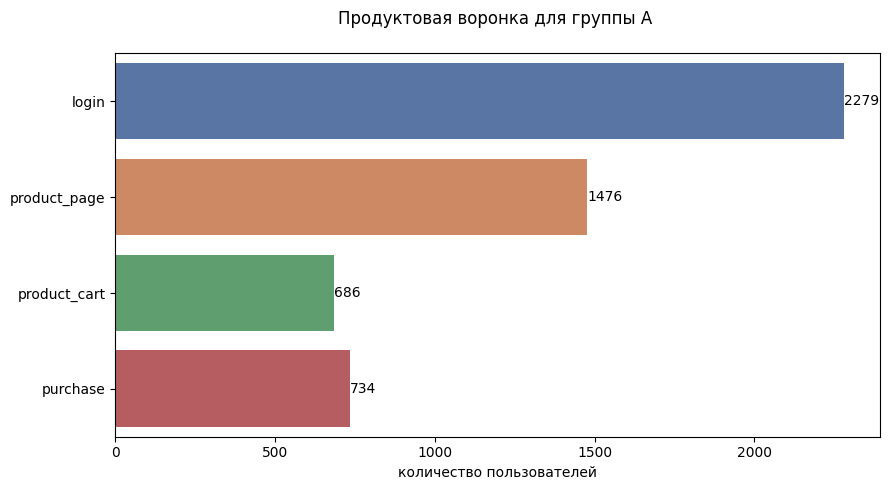

In [60]:
actions_x_users_A = (events.query('group == "A"') # pivot table for plot
                     .groupby('event_name')['user_id']
                     .nunique()
                     .reset_index())
actions_x_users_A.loc[0, 'sort'] = 0
actions_x_users_A.loc[2, 'sort'] = 1
actions_x_users_A.loc[1, 'sort'] = 2
actions_x_users_A.loc[3, 'sort'] = 3
actions_x_users_A = actions_x_users_A.sort_values(by='sort').rename(columns={'user_id':'user_cnt'})

fig, ax = plt.subplots()
fig.set(size_inches=(9, 5), tight_layout=True)

sns.barplot(data=actions_x_users_A, x='user_cnt', y='event_name', palette='deep');
ax.bar_label(ax.containers[0]);
ax.set(ylabel=None, xlabel='количество пользователей', title='Продуктовая воронка для группы А \n');

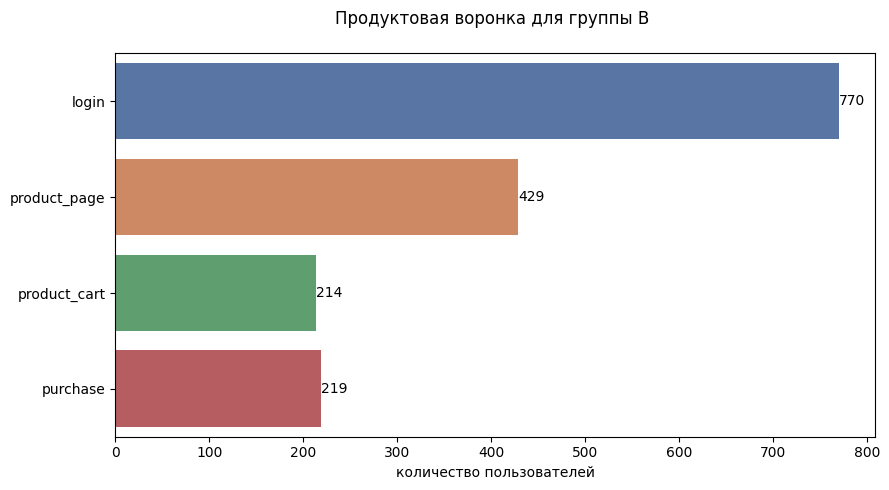

In [61]:
actions_x_users_B = (events.query('group == "B"')
                     .groupby('event_name')['user_id']
                     .nunique()
                     .reset_index())
actions_x_users_B.loc[0, 'sort'] = 0
actions_x_users_B.loc[2, 'sort'] = 1
actions_x_users_B.loc[1, 'sort'] = 2
actions_x_users_B.loc[3, 'sort'] = 3
actions_x_users_B = actions_x_users_B.sort_values(by='sort').rename(columns={'user_id':'user_cnt'})

fig, ax = plt.subplots()
fig.set(size_inches=(9, 5), tight_layout=True)

sns.barplot(data=actions_x_users_B, x='user_cnt', y='event_name', palette='deep');
ax.bar_label(ax.containers[0]);
ax.set(ylabel=None, xlabel='количество пользователей', title='Продуктовая воронка для группы В \n');

- Просмотр корзины -- не обязательное действие, можно приобрести товар без просмотра
- Группа В смотрится хуже на всех этапах воронки

### **Вывод**

- Распределение количества действий у пользователей в группах А и В совпадает по форме
    - Ключевое отличие: для группы А больше доля пользователей, совершивших 8-9 действий в сравнении с долей пользователей, совершивших 2-3 действий, а для группы В наоборот 
    - Среднее количество действий на пользователя в группе А больше на 23 %
- Динамика действий для групп отличается
    - По группе В нет выхода на плато с даты `2020-12-16` 
- Сравнение продуктовых воронок показывает ухудшение показателей для группы В
    - Все шаги с меньшей конверсий, наибольшая разница по событию `product_page`

## Анализ результатов теста

Применим z-тест для долей, чтобы оценить: является ли статистически значимым отклонение в конверсиях между группами?

In [62]:
alpha = .05 / 3

# iterating events
for i in ['product_page', 'product_cart', 'purchase']:
    target_users = []
    all_users = []

# iterating groups
    for j in ['A', 'B']:
        target_users.append(events
                            .query('group == @j and event_name == @i')['user_id']
                            .nunique())
        all_users.append(events
                            .query('group == @j')['user_id']
                            .nunique())
# calculating p-value        
    pval = proportions_ztest(target_users, all_users, alternative="two-sided")[1]
    
# printing results

    print('-----------------------')
    print(i)
    print()
    print(f'H0: Две группы демонстрируют одинаковую конверсию; статистически значимых отличий нет')
    print(f'H1: Две группы демонстрируют разную конверсию; статистически значимые отличия есть')
    print()
    print(f'конверсия А: {target_users[0] / all_users[0]:.3f} / конверсия В: {target_users[1] / all_users[1]:.3f}')
    if i == 'product_page':
        print(f'p-value: {pval:.2e}  / alpha: {alpha:.2f}')
    else: print(f'p-value: {pval:.2f}  / alpha: {alpha:.2f}')
    
    print()
    if pval < alpha:
        print('+ отвергаем нулевую гипотезу в пользу альтернативной')
    else: print('- не удалось отвергнуть нулевую гипотезу')

-----------------------
product_page

H0: Две группы демонстрируют одинаковую конверсию; статистически значимых отличий нет
H1: Две группы демонстрируют разную конверсию; статистически значимые отличия есть

конверсия А: 0.648 / конверсия В: 0.556
p-value: 6.12e-06  / alpha: 0.02

+ отвергаем нулевую гипотезу в пользу альтернативной
-----------------------
product_cart

H0: Две группы демонстрируют одинаковую конверсию; статистически значимых отличий нет
H1: Две группы демонстрируют разную конверсию; статистически значимые отличия есть

конверсия А: 0.301 / конверсия В: 0.278
p-value: 0.22  / alpha: 0.02

- не удалось отвергнуть нулевую гипотезу
-----------------------
purchase

H0: Две группы демонстрируют одинаковую конверсию; статистически значимых отличий нет
H1: Две группы демонстрируют разную конверсию; статистически значимые отличия есть

конверсия А: 0.322 / конверсия В: 0.284
p-value: 0.05  / alpha: 0.02

- не удалось отвергнуть нулевую гипотезу


### **Вывод**

- Для события `product_page` нулевая гипотеза отвергнута: нет оснований полагать, что конверсии одинаковы
    - Сравнение величин конверсий для группы А и В показывает снижение конверсии в тестовой группе
- Для событий `product_cart` и `purhcase` не удалось отвергнуть нулевую гипотезу: нет статистически значимого различия в конверсии между контрольной и тестовой группами 

## **Общий вывод**

**Предобработка**

- Пропуски в данных только в датасете `events` в колонке `details` 
    - Пропуски соответствуют всем событиям, не являющимся событием `purchase`, что соответствует описанию данных
    - Пропуски оставлены в первоначальном виде
- Дата приведена к типу `datetime`
- Обнаружены повторяющиеся `user_id` в `participants` -- 
    - Явление связано с участием одних и тех же пользователей в разных тестах
    - Удалены пересечения пользователей с группой В конкурирующего теста
    
**Проверка на корректность**

- Тест закончен раньше запланированного срока
- Доля новых пользователей из `EU` 13 % вместо 15 % -- снижен охват целевой аудитории тестом
- В тесте участвовали не только пользователи из `EU`, были убраны пользователи из других регионов, чтобы не размывать результат
- Общее число тестируемых ниже целевого: 5500 вместо 6000 по ТЗ
- Есть пересечение с маркетинговой кампанией `Christmas&New Year Promo` с `2020-12-25` и до конца теста (шесть дней)
    - Изменений в динамике событий после начала кампании не обнаружено для обеих групп
- Пользователи не относятся к двум группам сразу
- Есть пользователи, не совершившие ни одного действия
    - В вопросах конверсии действий такие пользователи бесполезны, они удалены
- Все действия за пределами двухнедельного лайфтайма пользователя удалены
- Размеры выборок соответствуют необходимым значениям регистрируемого эффекта, базовым конверсиям и уровню статистической значимости (с поправкой на множественные тесты) 
- Распределение по устройствам в группах совпадает
- Тест пригоден для изучения

**Исследовательский анализ**

- Распределение количества действий у пользователей в группах А и В совпадает по форме
    - Ключевое отличие: для группы А больше доля пользователей, совершивших 8-9 действий в сравнении с долей пользователей, совершивших 2-3 действий, а для группы В наоборот 
    - Среднее количество действий на пользователя в группе А больше на 23 % -- здесь более активные пользователи  
- Динамика действий для групп отличается
    - По группе В нет резкого роста и выхода на высокие значения с `2020-12-13` 
- Сравнение продуктовых воронок показывает ухудшение показателей для группы В
    - Все шаги с меньшей конверсий, наибольшая разница по событию `product_page`
    

**Анализ результатов теста**
  
   - Для события `product_page` нулевая гипотеза отвергнута: нет оснований полагать, что конверсии одинаковы
    - Сравнение величин конверсий для группы А и В показывает снижение конверсии в тестовой группе
- Для событий `product_cart` и `purhcase` не удалось отвергнуть нулевую гипотезу: нет статистически значимого различия в конверсии между контрольной и тестовой группами  


**Рекомендации**

Не рекомендуется масштабировать улучшенную рекомендательную систему на всех пользователей